# Lecture 8: Linear Models for Prediction - Building Your First Predictive Engine

## Learning Objectives

By the end of this lecture, you will be able to:
- Understand linear regression fundamentals and their mathematical foundation
- Implement linear regression using scikit-learn's LinearRegression class
- Create proper train-test splits to evaluate model performance on unseen data
- Apply chronological splitting strategies for time series forecasting problems
- Use cross-validation techniques to obtain robust performance estimates

---

## 1. Your Predictive Modeling Journey Begins

### The Consultant's Next Challenge: From Data to Predictions

Six months into your consulting engagement with Capital City Bikes, your expertise in data preparation and feature engineering has transformed raw operational data into a sophisticated analytical foundation. The client's CEO approaches you with an urgent new challenge: "We need to predict demand for next week to optimize our bike distribution and staffing decisions. Our investors want to see concrete forecasting capabilities before our Series A funding round."

This is **the moment every data consultant anticipates** - moving beyond descriptive analysis to build predictive capabilities that directly drive business decisions. Just as a bridge engineer progresses from understanding materials and forces to designing structures that bear actual loads, you're transitioning from data preparation to building models that must perform reliably in real business conditions.

### Why Linear Regression: The Foundation of Predictive Intelligence

Think of linear regression as learning to drive with a manual transmission before advancing to complex automated systems. While sophisticated machine learning algorithms like neural networks and ensemble methods can achieve impressive accuracy, they often function as "black boxes" that provide predictions without explanation. Linear regression, by contrast, offers **transparency that's essential for building stakeholder confidence** and business understanding.

Linear regression serves multiple crucial purposes in your consulting toolkit. First, it **establishes baseline performance** that more complex models must exceed to justify their additional complexity. Second, it provides interpretable insights that help stakeholders understand which factors actually drive their business outcomes. Third, it offers rapid development cycles that enable quick iteration and learning, particularly valuable in fast-moving startup environments.

These qualities become your competitive advantage as a consultant. While competitors might deliver accurate predictions through complex algorithms, you'll provide **predictions plus understanding**, enabling your client to make informed decisions and confidently communicate their analytical capabilities to investors and partners.

## 2. Linear Regression Fundamentals

This section establishes the mathematical and conceptual foundation of linear regression before exploring its implementation. We'll start by defining linear regression from first principles, then examine how linear relationships manifest in real data, understand the mathematics behind the regression line, and finally connect these concepts to practical business applications in urban mobility.

### 2.1. What is Linear Regression

Linear regression is **a statistical method that models the relationship between a dependent variable** (what we want to predict) **and one or more independent variables** (what we use to make predictions) by fitting a straight line through the data points. The fundamental assumption of linear regression is that the relationship between variables can be expressed as a linear equation, meaning that changes in the independent variables produce proportional changes in the dependent variable.

At its core, linear regression seeks to find the "best-fit" line that minimizes the distance between the actual data points and the predicted values on the line. This line represents the average relationship between the input variables and the target variable, allowing us to make predictions for new, unseen data points.

The power of linear regression lies in **its simplicity and interpretability**. Unlike complex algorithms that act as "black boxes," linear regression provides clear, understandable relationships that can be easily communicated to stakeholders. Each coefficient in the model tells us exactly how much the target variable is expected to change when the corresponding input variable increases by one unit, holding all other variables constant.

In the context of predictive modeling, linear regression serves as both a practical prediction tool and a baseline for comparison with more sophisticated algorithms. Its transparency makes it particularly valuable in business contexts where understanding the "why" behind predictions is as important as the predictions themselves.

Let's see how linear relationships appear in real bike-sharing data:

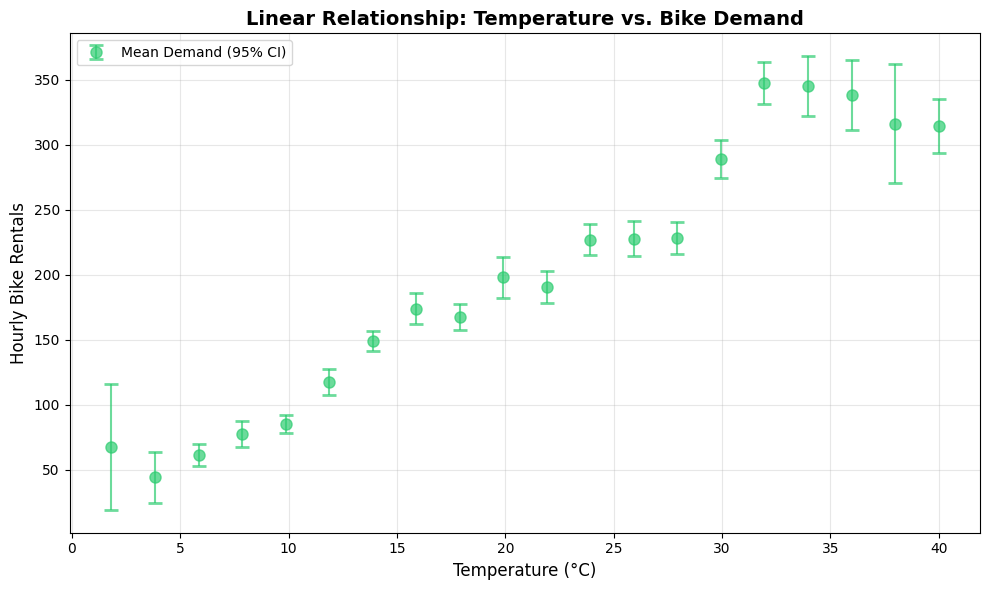

Temperature-Demand Correlation: 0.394
Temperature explains 15.6% of demand variation


In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# We'll use scipy's linregress() function, which calculates the best-fit line
# using the same ordinary least squares method. It returns the slope, intercept,
# correlation coefficient, and other statistics we'll use for analysis.

# Load the bike-sharing dataset
df = pd.read_csv("https://raw.githubusercontent.com/pmarcelino/predictive-modeling/main/datasets/dataset.csv")
df['datetime'] = pd.to_datetime(df['datetime'])

# Create temperature bins to reduce visual clutter and calculate statistics
# Standard error (SE) measures uncertainty in our mean estimates: SE = std / √n
# Multiplying SE by 1.96 creates 95% confidence intervals - the range where
# we expect the true mean demand to fall with 95% confidence
df['temp_bin'] = pd.cut(df['temp'], bins=20)
binned = df.groupby('temp_bin', observed=True)['count'].agg(['mean', 'std', 'count'])
binned['se'] = binned['std'] / np.sqrt(binned['count'])
binned['temp_center'] = binned.index.map(lambda x: x.mid)

# Create binned scatter plot with confidence intervals
plt.figure(figsize=(10, 6))
plt.errorbar(binned['temp_center'], binned['mean'], 
            yerr=binned['se']*1.96,  # 95% confidence interval
            fmt='o', markersize=8, capsize=5, capthick=2,
            color='#2ECC71', ecolor='#2ECC71', alpha=0.7,
            label='Mean Demand (95% CI)')
plt.xlabel('Temperature (°C)', fontsize=12)
plt.ylabel('Hourly Bike Rentals', fontsize=12)
plt.title('Linear Relationship: Temperature vs. Bike Demand', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate correlation to quantify relationship strength
correlation = df['temp'].corr(df['count'])
print(f"Temperature-Demand Correlation: {correlation:.3f}")
print(f"Temperature explains {(correlation**2)*100:.1f}% of demand variation")

**What this demonstrates:**
- **Visual evidence of linear relationships** in transportation data - warmer temperatures generally associate with higher demand
- The moderate correlation (r ≈ 0.39) indicates that while temperature matters, other factors also influence demand significantly
- Confidence intervals (error bars) show consistent patterns across temperature ranges, with slightly wider intervals at extremes due to fewer observations

### 2.2. Linear Relationships in Data

A linear relationship exists when **two variables change together at a constant rate**. In mathematical terms, this means that as one variable increases or decreases, the other variable changes by a consistent amount. When plotted on a graph, these relationships appear as straight lines, hence the term "linear."

Linear relationships can be positive or negative. In a positive linear relationship, both variables move in the same direction - as one increases, the other increases proportionally. In a negative linear relationship, the variables move in opposite directions - as one increases, the other decreases proportionally. **The strength of a linear relationship is measured by how closely the data points cluster around the best-fit line.**

Real-world data rarely exhibits perfect linear relationships, but many phenomena demonstrate approximately linear patterns that can be effectively modeled using linear regression. The key is identifying variables that have reasonably consistent relationships with each other, even if some variability exists around the general trend.

Let's visualize both positive and negative linear relationships in bike-sharing data:

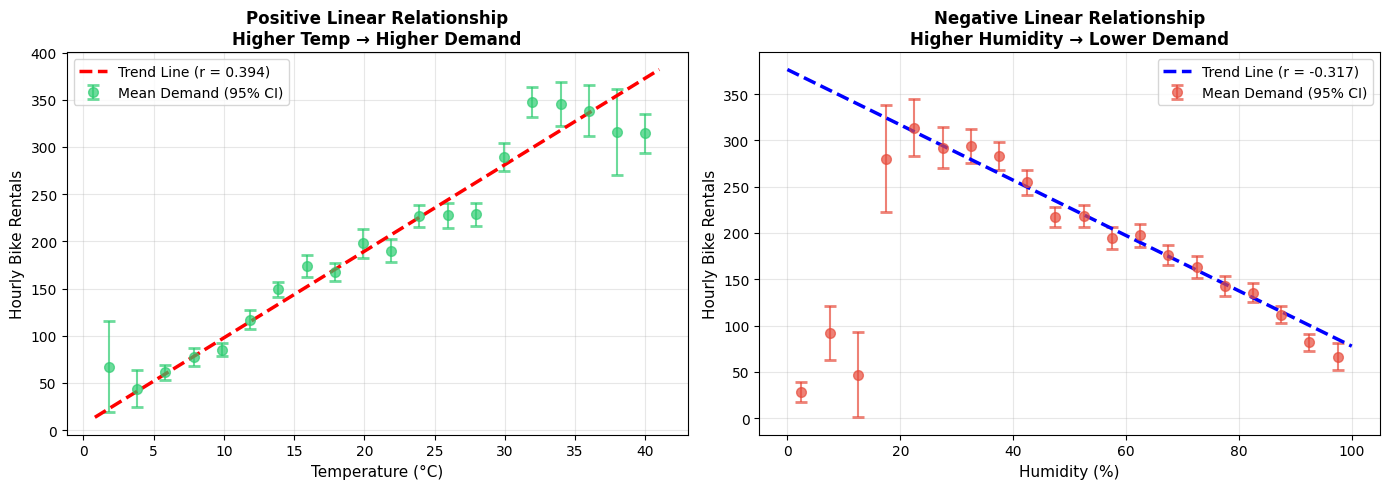

=== Linear Relationship Analysis ===
Temperature (positive): r = 0.394, slope = 9.17 rides/°C
Humidity (negative): r = -0.317, slope = -2.99 rides/%


In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Load the bike-sharing dataset
df = pd.read_csv("https://raw.githubusercontent.com/pmarcelino/predictive-modeling/main/datasets/dataset.csv")
df['datetime'] = pd.to_datetime(df['datetime'])

# Create bins for temperature and humidity to reduce visual clutter
df['temp_bin'] = pd.cut(df['temp'], bins=20)
df['humidity_bin'] = pd.cut(df['humidity'], bins=20)

# Aggregate temperature data
temp_binned = df.groupby('temp_bin', observed=True)['count'].agg(['mean', 'std', 'count'])
temp_binned['se'] = temp_binned['std'] / np.sqrt(temp_binned['count'])
temp_binned['temp_center'] = temp_binned.index.map(lambda x: x.mid)

# Aggregate humidity data
humidity_binned = df.groupby('humidity_bin', observed=True)['count'].agg(['mean', 'std', 'count'])
humidity_binned['se'] = humidity_binned['std'] / np.sqrt(humidity_binned['count'])
humidity_binned['humidity_center'] = humidity_binned.index.map(lambda x: x.mid)

# Create side-by-side plots showing positive and negative relationships
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel 1: Positive relationship (Temperature vs. Demand)
axes[0].errorbar(temp_binned['temp_center'], temp_binned['mean'],
                yerr=temp_binned['se']*1.96,  # 95% confidence interval
                fmt='o', markersize=7, capsize=4, capthick=2,
                color='#2ECC71', ecolor='#2ECC71', alpha=0.7,
                label='Mean Demand (95% CI)')
slope1, intercept1, r1, _, _ = stats.linregress(df['temp'], df['count'])
line_x1 = np.array([df['temp'].min(), df['temp'].max()])
axes[0].plot(line_x1, slope1 * line_x1 + intercept1, 'r--', linewidth=2.5,
             label=f'Trend Line (r = {r1:.3f})')
axes[0].set_xlabel('Temperature (°C)', fontsize=11)
axes[0].set_ylabel('Hourly Bike Rentals', fontsize=11)
axes[0].set_title('Positive Linear Relationship\nHigher Temp → Higher Demand',
                  fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Panel 2: Negative relationship (Humidity vs. Demand)
axes[1].errorbar(humidity_binned['humidity_center'], humidity_binned['mean'],
                yerr=humidity_binned['se']*1.96,  # 95% confidence interval
                fmt='o', markersize=7, capsize=4, capthick=2,
                color='#E74C3C', ecolor='#E74C3C', alpha=0.7,
                label='Mean Demand (95% CI)')
slope2, intercept2, r2, _, _ = stats.linregress(df['humidity'], df['count'])
line_x2 = np.array([df['humidity'].min(), df['humidity'].max()])
axes[1].plot(line_x2, slope2 * line_x2 + intercept2, 'b--', linewidth=2.5,
             label=f'Trend Line (r = {r2:.3f})')
axes[1].set_xlabel('Humidity (%)', fontsize=11)
axes[1].set_ylabel('Hourly Bike Rentals', fontsize=11)
axes[1].set_title('Negative Linear Relationship\nHigher Humidity → Lower Demand',
                  fontsize=12, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("=== Linear Relationship Analysis ===")
print(f"Temperature (positive): r = {r1:.3f}, slope = {slope1:.2f} rides/°C")
print(f"Humidity (negative): r = {r2:.3f}, slope = {slope2:.2f} rides/%")

**What this demonstrates:**
- **Positive linear relationships** show upward trends - as temperature increases, demand increases consistently
- **Negative linear relationships** show downward trends - as humidity increases, demand decreases
- The correlation coefficients (r values) quantify relationship strength - temperature shows moderate positive correlation, humidity shows moderate negative correlation
- The slopes tell the business story: each 1°C temperature increase adds approximately 9.2 rides per hour, while each 1% humidity increase reduces demand by approximately 2.2 rides per hour
- These quantified relationships enable **concrete operational planning** and weather-responsive capacity adjustments

### 2.3. The Regression Line

The regression line, also known as **the line of best fit**, is the mathematical representation of the linear relationship between variables. For simple linear regression with one independent variable, this line is expressed using the familiar equation: `y = mx + b`, where y is the dependent variable, x is the independent variable, m is the slope, and b is the y-intercept. The slope (m) represents the rate of change - how much y increases or decreases for every one-unit increase in x. The y-intercept (b) represents the value of y when x equals zero. Together, these parameters define the position and angle of the line that best represents the relationship in the data.

For multiple linear regression, which involves more than one independent variable, the equation extends to: y = b₀ + b₁x₁ + b₂x₂ + ... + bₙxₙ, where b₀ is the intercept, and b₁, b₂, through bₙ are the coefficients for each independent variable x₁, x₂, through xₙ. Each coefficient represents the expected change in y for a one-unit increase in the corresponding x variable, assuming all other variables remain constant.

The process of finding the best regression line involves **minimizing the sum of squared differences** between the actual data points and the predicted values on the line. This method, called ordinary least squares, ensures that the line represents the best possible fit given the available data. The resulting line minimizes prediction errors across all data points, providing the most accurate representation of the underlying relationship.

The quality of the regression line is measured by how well it explains the variability in the data. A perfect fit would have all data points lying exactly on the line, while a poor fit would show data points scattered widely around the line with no clear pattern.

Let's calculate and visualize a regression line with its equation parameters:

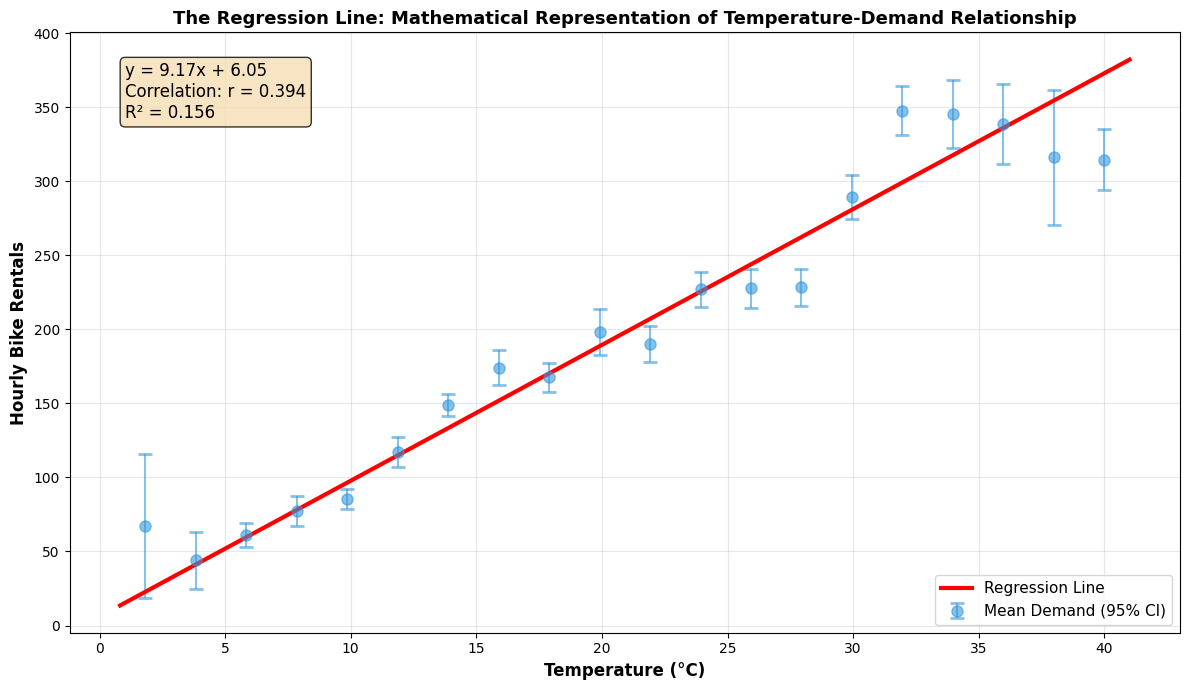


=== Using the Regression Equation for Predictions ===
Regression Equation: Demand = 9.17 × Temperature + 6.05

At 10°C: Predicted demand = 98 rides per hour
At 15°C: Predicted demand = 144 rides per hour
At 20°C: Predicted demand = 189 rides per hour
At 25°C: Predicted demand = 235 rides per hour
At 30°C: Predicted demand = 281 rides per hour

Interpretation:
- Slope (9.17): Each 1°C increase adds ~9 rides per hour
- Intercept (6.05): Baseline demand at 0°C would be ~6 rides
- R² (0.156): Temperature explains 15.6% of demand variation


In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Load the bike-sharing dataset
df = pd.read_csv("https://raw.githubusercontent.com/pmarcelino/predictive-modeling/main/datasets/dataset.csv")
df['datetime'] = pd.to_datetime(df['datetime'])

# Calculate regression line parameters using original data
slope, intercept, r_value, p_value, std_err = stats.linregress(df['temp'], df['count'])

# Create temperature bins to reduce visual clutter
df['temp_bin'] = pd.cut(df['temp'], bins=20)
binned = df.groupby('temp_bin', observed=True)['count'].agg(['mean', 'std', 'count'])
binned['se'] = binned['std'] / np.sqrt(binned['count'])
binned['temp_center'] = binned.index.map(lambda x: x.mid)

# Create visualization showing the regression line
plt.figure(figsize=(12, 7))

# Plot binned data with confidence intervals
plt.errorbar(binned['temp_center'], binned['mean'],
            yerr=binned['se']*1.96,  # 95% confidence interval
            fmt='o', markersize=8, capsize=5, capthick=2,
            color='#3498DB', ecolor='#3498DB', alpha=0.6,
            label='Mean Demand (95% CI)')

# Plot the regression line
line_x = np.array([df['temp'].min(), df['temp'].max()])
line_y = slope * line_x + intercept
plt.plot(line_x, line_y, 'r-', linewidth=3, label='Regression Line')

# Add equation annotation
equation_text = f'y = {slope:.2f}x + {intercept:.2f}\n'
equation_text += f'Correlation: r = {r_value:.3f}\n'
equation_text += f'R² = {r_value**2:.3f}'
plt.text(0.05, 0.95, equation_text, transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.xlabel('Temperature (°C)', fontsize=12, fontweight='bold')
plt.ylabel('Hourly Bike Rentals', fontsize=12, fontweight='bold')
plt.title('The Regression Line: Mathematical Representation of Temperature-Demand Relationship',
          fontsize=13, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Demonstrate prediction using the regression equation
example_temps = [10, 15, 20, 25, 30]
print("\n=== Using the Regression Equation for Predictions ===")
print(f"Regression Equation: Demand = {slope:.2f} × Temperature + {intercept:.2f}\n")
for temp in example_temps:
    predicted_demand = slope * temp + intercept
    print(f"At {temp}°C: Predicted demand = {predicted_demand:.0f} rides per hour")

print(f"\nInterpretation:")
print(f"- Slope ({slope:.2f}): Each 1°C increase adds ~{slope:.0f} rides per hour")
print(f"- Intercept ({intercept:.2f}): Baseline demand at 0°C would be ~{intercept:.0f} rides")
print(f"- R² ({r_value**2:.3f}): Temperature explains {(r_value**2)*100:.1f}% of demand variation")

**What this demonstrates:**
- The slope parameter quantifies the temperature effect: approximately 9.2 additional rides per hour for each degree Celsius increase
- The intercept provides the theoretical baseline demand (though 0°C is outside typical operating conditions)
- **R² (coefficient of determination)** reveals that temperature alone explains only 15.5% of demand variation, indicating other factors matter significantly
- The equation enables **scenario planning**: managers can estimate demand at different forecasted temperatures

## 3. Machine Learning Implementation

This section transitions from mathematical theory to practical implementation using machine learning tools. We'll build your understanding step by step: first mastering the LinearRegression tool itself, then understanding why proper evaluation matters, learning to create train-test splits, adapting for time series data, gaining robust performance estimates through cross-validation, and finally diving deep into performance metrics. This systematic progression ensures you can confidently deploy linear regression models for real-world demand forecasting.

### 3.1. From Mathematics to Code

The transition from mathematical concepts to computational implementation represents **a crucial step in applying linear regression to real-world problems**. While the underlying mathematics remains the same, machine learning libraries provide optimized implementations that handle the computational complexity and offer additional functionality for model management and evaluation.

**The scikit-learn library** provides a comprehensive implementation of linear regression that automates the process of finding optimal coefficients through mathematical optimization algorithms. These implementations efficiently handle large datasets, multiple variables, and various data types while maintaining numerical stability and computational efficiency.

Let's see the complete journey from manual calculation to automated scikit-learn implementation:

In [64]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy import stats

# Load the bike-sharing dataset
df = pd.read_csv("https://raw.githubusercontent.com/pmarcelino/predictive-modeling/main/datasets/dataset.csv")
df['datetime'] = pd.to_datetime(df['datetime'])

print("=== FROM MATHEMATICS TO CODE ===\n")

# Method 1: Manual calculation using scipy (shows the mathematics)
print("--- Method 1: Mathematical Approach (scipy) ---")
slope, intercept, r_value, p_value, std_err = stats.linregress(df['temp'], df['count'])
print(f"Equation: Demand = {slope:.2f} × Temperature + {intercept:.2f}")
print(f"R-squared: {r_value**2:.3f}")
print(f"Standard error: {std_err:.2f}")

# Manual prediction
example_temp = 20
manual_prediction = slope * example_temp + intercept
print(f"Manual prediction at {example_temp}°C: {manual_prediction:.0f} rides\n")

# Method 2: Machine learning approach (scikit-learn)
print("--- Method 2: Machine Learning Approach (scikit-learn) ---")
# Prepare data in scikit-learn format (2D array for features)
X = df[['temp']]  # Must be 2D for scikit-learn
y = df['count']

# Create and train the model
ml_model = LinearRegression()
ml_model.fit(X, y)

# Extract parameters (same as manual calculation)
ml_slope = ml_model.coef_[0]
ml_intercept = ml_model.intercept_
print(f"Equation: Demand = {ml_slope:.2f} × Temperature + {ml_intercept:.2f}")

# Calculate R-squared using scikit-learn's metrics module
# r2_score() computes the coefficient of determination (R²), which measures
# how well the model explains variance in the target variable
ml_predictions = ml_model.predict(X)
from sklearn.metrics import r2_score
ml_r2 = r2_score(y, ml_predictions)
print(f"R-squared: {ml_r2:.3f}")

# ML prediction (use DataFrame to match training format)
example_input = pd.DataFrame({'temp': [example_temp]})
ml_prediction = ml_model.predict(example_input)[0]
print(f"ML prediction at {example_temp}°C: {ml_prediction:.0f} rides\n")

# Verify equivalence
print("--- Verification: Both Methods Produce Identical Results ---")
print(f"Slopes match: {abs(slope - ml_slope) < 0.01}")
print(f"Intercepts match: {abs(intercept - ml_intercept) < 0.01}")
print(f"Predictions match: {abs(manual_prediction - ml_prediction) < 0.01}")

print("\n--- Key Advantages of ML Implementation ---")
print("✓ Standardized interface works with all scikit-learn algorithms")
print("✓ Easy extension to multiple features (just add columns)")
print("✓ Built-in performance metrics and cross-validation")
print("✓ Numerical stability for large datasets")
print("✓ Integration with pipelines and preprocessing tools")

=== FROM MATHEMATICS TO CODE ===

--- Method 1: Mathematical Approach (scipy) ---
Equation: Demand = 9.17 × Temperature + 6.05
R-squared: 0.156
Standard error: 0.20
Manual prediction at 20°C: 189 rides

--- Method 2: Machine Learning Approach (scikit-learn) ---
Equation: Demand = 9.17 × Temperature + 6.05
R-squared: 0.156
ML prediction at 20°C: 189 rides

--- Verification: Both Methods Produce Identical Results ---
Slopes match: True
Intercepts match: True
Predictions match: True

--- Key Advantages of ML Implementation ---
✓ Standardized interface works with all scikit-learn algorithms
✓ Easy extension to multiple features (just add columns)
✓ Built-in performance metrics and cross-validation
✓ Numerical stability for large datasets
✓ Integration with pipelines and preprocessing tools


**What this demonstrates:**
- **Mathematical and machine learning approaches produce identical results** - the ML implementation is simply automating the mathematics we've learned
- This equivalence validation builds confidence: you understand both the mathematics and the implementation
- The scikit-learn interface provides a **consistent pattern** (e.g., fit, predict, score) that works across all algorithms, simplifying future learning
- **Transitioning to ML tools** enables scaling from simple models (one feature) to complex models (many features) without changing your code structure

### 3.2. Basic Model Usage

Now that we understand how scikit-learn automates the mathematics, let's master the LinearRegression class mechanics before diving into evaluation complexities. We'll focus purely on the tool itself: how to create models, train them, make predictions, and interpret the learned parameters. Think of this as learning to drive a car before worrying about navigation or traffic rules.

The scikit-learn LinearRegression class provides **a standardized interface** that makes machine learning accessible and consistent. The beauty of this interface is its simplicity: every model in scikit-learn follows the same pattern, which means once you master linear regression, you already know how to use decision trees, neural networks, and hundreds of other algorithms.

**The core LinearRegression workflow** consists of just three essential steps: create the model object, fit it to data, and use it to make predictions. This pattern remains identical whether you're building simple single-feature models or complex multi-feature systems, providing a solid foundation for all your machine learning work.

Let's start by understanding **the key components** of the LinearRegression class:

1. When you create a model, you're instantiating an object that can learn relationships from data.
2. When you call `.fit()`, the model analyzes your data to find optimal coefficients.
3. When you call `.predict()`, it applies those learned relationships to new data.

These three operations form the backbone of machine learning with scikit-learn. **After fitting**, the model stores its learned parameters in special attributes. The `.coef_` attribute contains the coefficients (slopes) for each feature, showing how much each factor influences your predictions. The `.intercept_` attribute stores the baseline value when all features are zero. Together, these parameters define the linear equation the model discovered in your data.

Let's explore the LinearRegression class step by step:

In [65]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# Load the bike-sharing dataset
df = pd.read_csv("https://raw.githubusercontent.com/pmarcelino/predictive-modeling/main/datasets/dataset.csv")
df['datetime'] = pd.to_datetime(df['datetime'])

print("=== BASIC LINEAR REGRESSION USAGE ===\n")

# Step 1: Prepare data
print("--- Step 1: Data Preparation ---")
feature_columns = ['temp', 'humidity', 'windspeed', 'workingday']
X = df[feature_columns]  # Features must be a 2D DataFrame
y = df['count']          # Target is a 1D Series

print(f"Dataset size: {len(df):,} hourly observations")
print(f"Feature matrix: {X.shape[0]} rows × {X.shape[1]} features")
print(f"Features: {list(X.columns)}")
print(f"Target: count (hourly bike rentals)\n")

# Step 2: Create and train the model
print("--- Step 2: Model Creation and Training ---")
model = LinearRegression()  # Create model with default parameters
print(f"Model created: {model}")

model.fit(X, y)  # Train the model on ALL available data
print("Model trained on complete dataset!")
print(f"Training completed for {X.shape[0]:,} observations\n")

# Step 3: Inspect learned parameters
print("--- Step 3: Inspect Learned Parameters ---")
print(f"Intercept (β₀): {model.intercept_:.2f} rides")
print("\nCoefficients (slopes):")
for feature, coef in zip(feature_columns, model.coef_):
    direction = "increases" if coef > 0 else "decreases"
    print(f"  {feature:12s}: {coef:+8.2f} → demand {direction} by {abs(coef):.2f} rides per unit")

print("\n--- Model Equation ---")
equation = f"Predicted Demand = {model.intercept_:.1f}"
for feature, coef in zip(feature_columns, model.coef_):
    sign = "+" if coef >= 0 else "-"
    equation += f" {sign} {abs(coef):.1f}×{feature}"
print(equation + "\n")

# Step 4: Make predictions
print("--- Step 4: Making Predictions ---")
predictions = model.predict(X)  # Predict for all observations
print(f"Generated {len(predictions):,} predictions")
print(f"First 5 predictions: {predictions[:5].round(1)}")
print(f"First 5 actual values: {y.iloc[:5].values}")

# Compare a few predictions
print("\n--- Prediction Examples ---")
for i in range(3):
    actual = y.iloc[i]
    predicted = predictions[i]
    error = actual - predicted
    print(f"Observation {i+1}: Actual = {actual:.0f}, Predicted = {predicted:.0f}, Error = {error:+.0f} rides")

# Step 5: Predict new scenarios
print("\n--- Step 5: New Scenario Prediction ---")
new_scenario = pd.DataFrame({
    'temp': [25],         # 25°C temperature
    'humidity': [50],     # 50% humidity
    'windspeed': [10],    # 10 km/h windspeed
    'workingday': [1]     # Working day
})
new_prediction = model.predict(new_scenario)[0]
print(f"Scenario: Warm working day (25°C, 50% humidity, 10 km/h wind)")
print(f"Predicted hourly demand: {new_prediction:.0f} bikes")

print("\n--- Key Takeaways ---")
print("✓ LinearRegression() creates a model object ready to learn")
print("✓ .fit(X, y) trains the model by finding optimal coefficients")
print("✓ .predict(X) applies learned relationships to make predictions")
print("✓ .coef_ and .intercept_ reveal what the model learned")
print("✓ The same simple pattern works for any number of features")

=== BASIC LINEAR REGRESSION USAGE ===

--- Step 1: Data Preparation ---
Dataset size: 10,886 hourly observations
Feature matrix: 10886 rows × 4 features
Features: ['temp', 'humidity', 'windspeed', 'workingday']
Target: count (hourly bike rentals)

--- Step 2: Model Creation and Training ---
Model created: LinearRegression()
Model trained on complete dataset!
Training completed for 10,886 observations

--- Step 3: Inspect Learned Parameters ---
Intercept (β₀): 178.39 rides

Coefficients (slopes):
  temp        :    +8.75 → demand increases by 8.75 rides per unit
  humidity    :    -2.71 → demand decreases by 2.71 rides per unit
  windspeed   :    +0.37 → demand increases by 0.37 rides per unit
  workingday  :    -1.18 → demand decreases by 1.18 rides per unit

--- Model Equation ---
Predicted Demand = 178.4 + 8.7×temp - 2.7×humidity + 0.4×windspeed - 1.2×workingday

--- Step 4: Making Predictions ---
Generated 10,886 predictions
First 5 predictions: [45.1 40.6 40.6 61.3 61.3]
First 5 ac

**What this demonstrates:**
- **Three-step workflow** (create → fit → predict) applies to all scikit-learn algorithms, providing a consistent foundation for your machine learning journey
- **Mathematical automation** - when you called `model.fit(X, y)`, scikit-learn solved equations behind the scenes to find optimal coefficients from 10,886 observations
- **Deterministic predictions** - given the same input features, the model always produces identical results, essential for reliable operational forecasting
- **Seamless scalability** - the same `fit → predict` workflow handles 4 features or 40 features identically
- **Transition from description to prediction** - you've moved beyond reporting past demand to forecasting future demand, transforming data analysis into actionable business intelligence

### 3.3. Why We Need Separate Test Data

Now that we can train models and make predictions, a critical question arises: how do we know if our model is any good? Looking at our previous example, the model made predictions for all 10,886 observations - but those are the same observations it used for training. Can we trust those predictions to tell us how well the model will perform on tomorrow's data?

**The fundamental challenge** in machine learning is distinguishing between models that have learned genuine patterns versus models that have simply memorized the training data. Imagine studying for an exam using practice problems. If the actual exam contains those exact same problems, a perfect score tells you nothing about whether you truly understand the concepts or just memorized the answers. The same principle applies to predictive models.

When we train a model on data and then evaluate it on that same data, we're essentially **giving it the exam questions during the study session**. The model can achieve high accuracy simply by memorizing the training examples, without learning the underlying patterns that would help it predict new situations. This memorization problem, called **overfitting**, produces models that look great on paper but fail in real-world deployment.

**Consider the Capital City Bikes scenario**: If our model memorizes that "on January 5th at 3pm it rained and 12 bikes were rented," that's useless for predicting February 10th's demand. What we need is for the model to learn that "rainy days typically reduce demand by 30%" - a general pattern that applies to any rainy day, not memorized facts about specific past days.

The solution is deceptively simple but absolutely crucial: **we must evaluate model performance on data the model has never seen**. To do this, we set aside a portion of the dataset during training and reserve it exclusively for testing. By comparing predictions on this unseen data, we can determine whether the model has truly learned meaningful patterns — or merely memorized the training examples. This process mirrors real-world practice, where our goal is to forecast tomorrow’s bike demand using only what we know from yesterday’s data.

When a model predicts well on held-out data it's never seen, we gain confidence that it learned genuine relationships. When training performance is much better than held-out performance, we know the model memorized rather than learned. This distinction is the difference between a model that's ready for business deployment and one that will fail in production.

Let's see this problem in action and understand why separate test data is essential:

In [66]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Scikit-learn's metrics module provides performance evaluation functions:
# - r2_score(): Measures how well predictions explain variance (0-1, higher is better)
# - mean_squared_error(): Calculates average squared prediction errors (lower is better)

# Load the bike-sharing dataset
df = pd.read_csv("https://raw.githubusercontent.com/pmarcelino/predictive-modeling/main/datasets/dataset.csv")
df['datetime'] = pd.to_datetime(df['datetime'])

print("=== THE TRAINING DATA EVALUATION PROBLEM ===\n")

# Prepare features and target
X = df[['temp', 'humidity', 'windspeed', 'workingday']]
y = df['count']

# Train a model on ALL data
print("--- Training model on complete dataset ---")
model = LinearRegression()
model.fit(X, y)
print(f"Model trained on {len(X):,} observations\n")

# Evaluate on the SAME data used for training
print("--- Evaluating on training data ---")
training_predictions = model.predict(X)
training_r2 = r2_score(y, training_predictions)
training_rmse = np.sqrt(mean_squared_error(y, training_predictions))

print(f"R² score: {training_r2:.4f} ({training_r2*100:.2f}% variance explained)")
print(f"RMSE: {training_rmse:.2f} rides")
print("\n❓ Question: Does this R² of {:.2f}% tell us how well the model will predict tomorrow's demand?".format(training_r2*100))
print("❓ Question: Can we trust this model for Capital City Bikes' operations?")

print("\n--- The Problem: We Can't Answer These Questions! ---")
print("\nWhy training performance is unreliable:")
print("1. Model has 'seen' all these observations during training")
print("2. High accuracy might mean genuine learning OR just memorization")
print("3. No way to distinguish between the two scenarios")
print("4. Real deployment requires predicting NEW data not in training set")

print("\n--- What We Need Instead ---")
print("✓ Evaluate on observations the model has NEVER seen")
print("✓ Simulate real-world scenario: predict future from past")
print("✓ Compare training vs testing performance to detect memorization")
print("✓ Trust metrics that reflect true predictive capability")

print("\n--- Real-World Deployment Scenario ---")
print("Capital City Bikes wants to predict next Monday's demand.")
print("The model must predict using:")
print("  • Weather features for Monday (temp, humidity, windspeed, workingday)")
print("  • Patterns learned from historical data (NOT Monday's actual demand)")
print("\nThe model will NEVER have 'seen' next Monday during training!")
print("Training data evaluation can't tell us how accurate Monday's prediction will be.")
print("\nConclusion: We need SEPARATE TEST DATA that simulates this future prediction scenario.")

=== THE TRAINING DATA EVALUATION PROBLEM ===

--- Training model on complete dataset ---
Model trained on 10,886 observations

--- Evaluating on training data ---
R² score: 0.2413 (24.13% variance explained)
RMSE: 157.77 rides

❓ Question: Does this R² of 24.13% tell us how well the model will predict tomorrow's demand?
❓ Question: Can we trust this model for Capital City Bikes' operations?

--- The Problem: We Can't Answer These Questions! ---

Why training performance is unreliable:
1. Model has 'seen' all these observations during training
2. High accuracy might mean genuine learning OR just memorization
3. No way to distinguish between the two scenarios
4. Real deployment requires predicting NEW data not in training set

--- What We Need Instead ---
✓ Evaluate on observations the model has NEVER seen
✓ Simulate real-world scenario: predict future from past
✓ Compare training vs testing performance to detect memorization
✓ Trust metrics that reflect true predictive capability

--- R

**What this demonstrates:**
- **Training data evaluation is circular logic** - testing on the same data used for training makes it impossible to distinguish learning from memorization
- **Real-world deployment requires unseen data** - our evaluation must simulate predicting future observations the model hasn't encountered
- **Performance ambiguity** - an R² of 34% on training data might indicate good learning or hide a model that performs far worse on new data

**The concept of overfitting** becomes clear through this lens. An overfitted model may achieve high training performance by memorizing specific examples rather than learning general patterns. It's like a student who memorizes answers without understanding concepts - perfect scores on practice problems, but failure on new exam questions. We can only detect overfitting by comparing training performance to performance on separate test data.

**This is why every machine learning project requires setting aside test data** before training begins. These held-out observations serve as a proxy for real-world deployment, giving us an honest assessment of whether the model learned patterns that generalize to new situations.

### 3.4. Train-Test Split for Time Series Forecasting

Now that we understand why separate test data is essential, let's learn how to create it properly for bike-sharing demand forecasting.

**The train-test split strategy** divides our dataset into two distinct subsets before any training occurs. The **training set** (typically 70-80% of data) is used to fit the model - this is the data the model learns from. The **testing set** (typically 20-30% of data) is held aside completely, never touching the training process, and used solely to evaluate the trained model's performance on unseen data.

The split must occur **before training begins** to ensure the test set truly simulates future data. If we peek at the test set during model development, adjust our approach based on test performance, or allow any information from the test set to influence training, we've violated the independence requirement and our evaluation becomes unreliable.

**Random splitting is the standard approach** for most machine learning problems. By randomly assigning observations to training and testing sets, we ensure both sets have similar distributions of all variables. This works beautifully when observations are independent - such as medical diagnoses from different patients, image classifications, or customer survey responses. Random splitting ensures fairness: both sets represent the same underlying patterns, just split into "training" and "testing" subsets.

**However, bike-sharing demand presents a special challenge**: the data has a time dimension. Each observation is tied to a specific date and hour, and demand patterns evolve over time due to seasonality, trends, and temporal dependencies. Can we still use random splitting, or does time order matter?

In bike-sharing data, today's demand influences tomorrow's - a holiday weekend may affect patterns for days afterward, seasonal trends build gradually, and weather patterns persist across hours. Random splitting ignores these temporal connections, potentially creating an unrealistic evaluation scenario.

**Chronological train-test split** is the correct solution for time series forecasting. This approach preserves temporal order by using the earliest portion of data for training and the most recent portion for testing. This mirrors real-world deployment: we train on all available history, then predict tomorrow, next week, or next month. The earliest 70-80% becomes training data, and the final 20-30% becomes test data, maintaining the timeline's integrity.

**The evaluation workflow** follows a strict sequence: chronological split → train on training set → predict on both sets → compare metrics. By generating predictions for both training and testing data, we can compare their performance metrics directly. When both show similar performance, the model learned generalizable patterns. When training performance significantly exceeds testing performance, the model overfitted.

Let's implement chronological splitting and proper model evaluation:

In [67]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Load the bike-sharing dataset
df = pd.read_csv("https://raw.githubusercontent.com/pmarcelino/predictive-modeling/main/datasets/dataset.csv")
df['datetime'] = pd.to_datetime(df['datetime'])

# Extract temporal features that capture demand patterns
df['hour'] = df['datetime'].dt.hour
# Hour captures daily patterns: rush hours (8am, 5-6pm) have 10x more demand than midnight

print("=== CHRONOLOGICAL TRAIN-TEST SPLIT FOR TIME SERIES ===\n")

# Step 1: Prepare features and target
print("--- Step 1: Data Preparation ---")
feature_columns = ['temp', 'humidity', 'windspeed', 'workingday', 'season', 'hour']
# We include temporal features (season, hour) because bike demand varies dramatically
# by time of day and season - critical patterns for forecasting
X = df[feature_columns]
y = df['count']
print(f"Total observations: {len(X):,}")
print(f"Time range: {df['datetime'].min()} to {df['datetime'].max()}")
print(f"Features: {feature_columns}\n")

# Step 2: Create chronological train-test split
print("--- Step 2: Chronological Train-Test Split ---")
split_index = int(len(df) * 0.8)  # First 80% for training

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

# Get corresponding dates for clarity
train_end_date = df.iloc[split_index-1]['datetime']
test_start_date = df.iloc[split_index]['datetime']

print(f"Training set: {len(X_train):,} observations ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Period: {df['datetime'].min()} to {train_end_date}")
print(f"\nTesting set: {len(X_test):,} observations ({len(X_test)/len(X)*100:.1f}%)")
print(f"  Period: {test_start_date} to {df['datetime'].max()}")
print(f"\n✓ Chronological order preserved - model trains on past, tests on future\n")

# Step 3: Train model on training data ONLY
print("--- Step 3: Train Model on Training Data ---")
model = LinearRegression()
model.fit(X_train, y_train)
print("Model trained successfully!")
print(f"Model learned from {len(X_train):,} historical observations\n")

# Step 4: Generate predictions for BOTH sets
print("--- Step 4: Generate Predictions ---")
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)
print(f"Training predictions: {len(train_predictions):,} values")
print(f"Testing predictions:  {len(test_predictions):,} values\n")

# Step 5: Evaluate performance on BOTH sets
print("--- Step 5: Compare Training vs Testing Performance ---")

# Calculate metrics for training set
train_r2 = r2_score(y_train, train_predictions)
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))

# Calculate metrics for testing set
test_r2 = r2_score(y_test, test_predictions)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

print("Training Performance (historical period):")
print(f"  R²:   {train_r2:.4f} ({train_r2*100:.1f}% variance explained)")
print(f"  RMSE: {train_rmse:.2f} rides per hour")

print("\nTesting Performance (future period - unseen data):")
print(f"  R²:   {test_r2:.4f} ({test_r2*100:.1f}% variance explained)")
print(f"  RMSE: {test_rmse:.2f} rides per hour")

# Detect overfitting by comparing performances
performance_gap = train_r2 - test_r2
print(f"\nPerformance Gap: {performance_gap:.4f}")
if performance_gap < 0.05:
    print("✓ Minimal gap - model learned generalizable patterns")
elif performance_gap < 0.15:
    print("⚠ Moderate gap - some overfitting present")
else:
    print("✗ Large gap - significant overfitting detected")

print("\n=== KEY INSIGHTS FOR CAPITAL CITY BIKES ===")
print(f"Test R²: {test_r2:.1%} represents realistic future prediction capability")
print(f"Test RMSE: {test_rmse:.0f} rides = typical prediction error when forecasting")
print(f"Performance gap: {performance_gap:.1%} (train R² - test R²)")
print(f"\nDeployment Assessment:")
if test_r2 > 0.30 and performance_gap < 0.05:
    print("✓ Model shows good performance - ready for operational deployment")
elif test_r2 > 0.10:
    print("⚠ Model shows moderate performance - useful for planning but needs improvement")
else:
    print("✗ Model shows poor performance - NOT ready for deployment")
    print("  Recommendation: Improve feature engineering before presenting to stakeholders")
print(f"\n✓ Chronological split simulates real forecasting: predict future from past")
print(f"✓ No temporal leakage - honest performance estimate")

=== CHRONOLOGICAL TRAIN-TEST SPLIT FOR TIME SERIES ===

--- Step 1: Data Preparation ---
Total observations: 10,886
Time range: 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Features: ['temp', 'humidity', 'windspeed', 'workingday', 'season', 'hour']

--- Step 2: Chronological Train-Test Split ---
Training set: 8,708 observations (80.0%)
  Period: 2011-01-01 00:00:00 to 2012-08-05 04:00:00

Testing set: 2,178 observations (20.0%)
  Period: 2012-08-05 05:00:00 to 2012-12-19 23:00:00

✓ Chronological order preserved - model trains on past, tests on future

--- Step 3: Train Model on Training Data ---
Model trained successfully!
Model learned from 8,708 historical observations

--- Step 4: Generate Predictions ---
Training predictions: 8,708 values
Testing predictions:  2,178 values

--- Step 5: Compare Training vs Testing Performance ---
Training Performance (historical period):
  R²:   0.3486 (34.9% variance explained)
  RMSE: 134.32 rides per hour

Testing Performance (future period - unse

**What this demonstrates:**
- **Modest predictive power** - test R² around 14-15% means the model explains only a small portion of demand variation
- **Linear regression limitations** revealed through struggles with linear assumptions, missing feature interactions, missing temporal features, and non-linear patterns
- **Missing temporal sophistication** - no lag variables, rolling averages, or day-of-week patterns that capture time series dynamics

### 3.5. Cross-Validation for Robust Evaluation

We've learned to evaluate models using a single train-test split, which provides one performance estimate. But here's a critical question: what if our particular test set happens to be unusually easy or difficult to predict? What if it contains only sunny weekdays, or happens to include an atypical holiday period? A single split gives us one number, but how confident should we be that this number represents true model performance?

**The single split limitation** arises from randomness in how we divide our data. Imagine Capital City Bikes gets an R² of 80% on one train-test split. Is this the model's true capability, or did the test set happen to be easy? If we created a different random split, would we get 30%? 40%? We can't know from a single evaluation. This uncertainty makes it difficult to compare models, tune parameters, or confidently report performance to stakeholders.

**Cross-validation solves this problem** by creating multiple train-test splits systematically and averaging their performance metrics. Instead of one evaluation giving one number, we get multiple evaluations giving multiple numbers - and their average provides a much more reliable estimate of model performance. The standard deviation across evaluations reveals performance consistency: low standard deviation means stable predictions regardless of data split, high standard deviation suggests the model is sensitive to training data composition.

A standard approach to cross-validation is the **Standard K-Fold Cross-Validation**, which divides data into K equal parts (typically K=5 or K=10). In each of K iterations, one part serves as the test set while the remaining K-1 parts form the training set. Every observation gets used for testing exactly once and for training K-1 times. This systematic rotation ensures no data is wasted and every part of the dataset contributes to both training and evaluation.

Here's how 5-fold cross-validation works: divide 10,886 observations into 5 parts of ~2,177 observations each. Fold 1 uses parts 2-5 for training and part 1 for testing. Fold 2 uses parts 1, 3-5 for training and part 2 for testing. This continues until all 5 parts have served as test set once. The result: 5 different R² scores from 5 different train-test configurations, giving us a robust performance estimate.

The problem is that **K-Fold fails for time series data**. This happens due to the temporal dependency problem we discussed in subsection 3.4. Standard k-fold creates random folds, potentially putting December observations in fold 2's training set and November observations in fold 3's test set. We're back to the same violation: training on "future" to predict "past." The temporal order gets scrambled across folds, creating data leakage and overly optimistic performance estimates.

**TimeSeriesSplit provides the time series solution** through forward-chaining evaluation. Instead of random folds, TimeSeriesSplit creates chronological folds where each fold's training set includes all previous data and its test set contains the next time period. This respects temporal order in every fold, always predicting future from past, just like real deployment.

Here's how TimeSeriesSplit works: Fold 1 trains on the earliest 20% of timeline and tests on the next 20%. Fold 2 trains on the first 40% and tests on the next 20%. Fold 3 trains on the first 60% and tests on the next 20%. Each fold simulates a realistic deployment scenario where we use all available history to predict the next time period. The training set grows with each fold (expanding window approach), while the test set advances chronologically through time.

Let's implement both approaches and understand when to use each:

=== CROSS-VALIDATION FOR ROBUST EVALUATION ===

Dataset: 10,886 hourly observations
Time range: 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Features: ['temp', 'humidity', 'windspeed', 'workingday', 'season', 'hour']

--- BASELINE: Single Chronological Train-Test Split ---
Single split R²: 0.1383
Question: Is this representative of true model performance?
Question: What if this particular test period is unusually easy or hard?
Answer: We need multiple evaluations to know!

--- TimeSeriesSplit Cross-Validation ---
✓ Multiple chronological splits for robust evaluation

TimeSeriesSplit Results (5 folds):
  Fold 1: R² = 0.2164
    Training: 2011-01-01 00:00:00 to 2011-05-02 13:00:00 (1,816 obs)
    Testing:  2011-05-02 14:00:00 to 2011-09-02 03:00:00 (1,814 obs)
  Fold 2: R² = 0.2041
    Training: 2011-01-01 00:00:00 to 2011-09-02 03:00:00 (3,630 obs)
    Testing:  2011-09-02 04:00:00 to 2012-01-01 21:00:00 (1,814 obs)
  Fold 3: R² = 0.0983
    Training: 2011-01-01 00:00:00 to 2012-01-01 21:

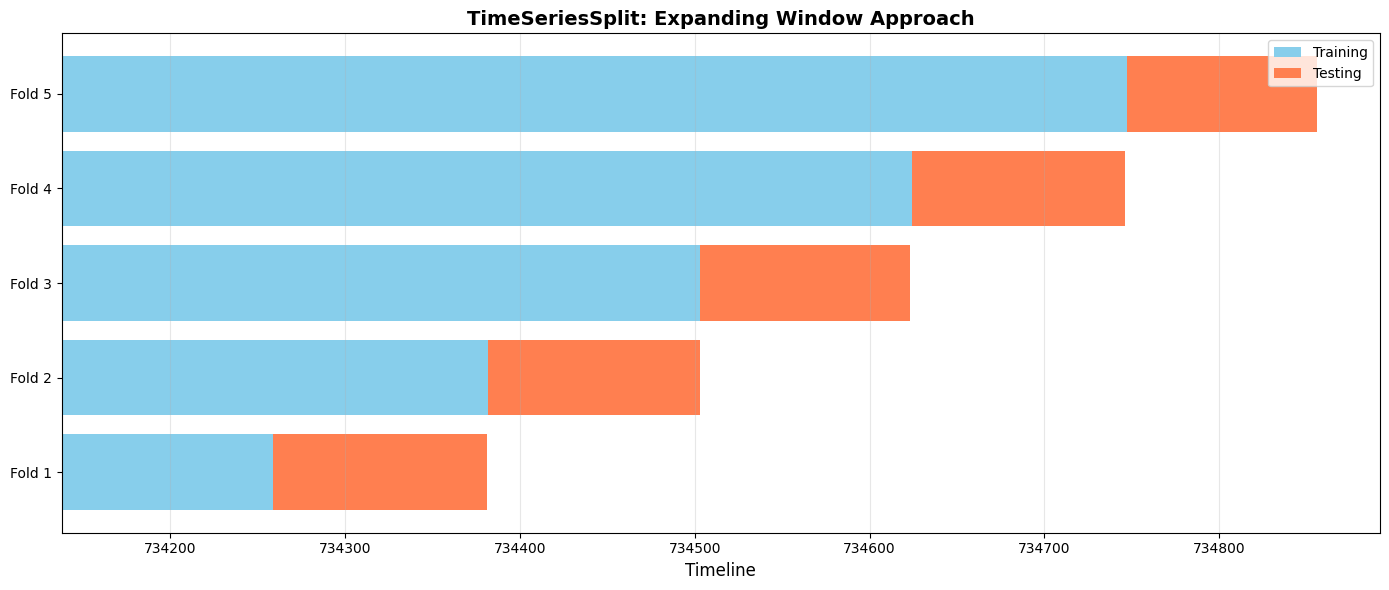


=== KEY INSIGHTS FOR CAPITAL CITY BIKES ===
✓ Cross-validation provides 5 performance estimates instead of 1
✓ Mean R² of 0.1680 is more reliable than single split
✓ Standard deviation of 0.0531 shows performance consistency
✓ TimeSeriesSplit respects temporal order (essential for forecasting)
✓ Each fold tests realistic deployment: predict future from past

Recommendation: Report CV mean ± std as model performance estimate
Capital City Bikes can confidently report: R² = 0.17 ± 0.05


In [68]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Load the bike-sharing dataset
df = pd.read_csv("https://raw.githubusercontent.com/pmarcelino/predictive-modeling/main/datasets/dataset.csv")
df['datetime'] = pd.to_datetime(df['datetime'])

print("=== CROSS-VALIDATION FOR ROBUST EVALUATION ===\n")

# Prepare features and target (same enhanced features from Section 3.4)
# Extract temporal features
df['hour'] = df['datetime'].dt.hour
df['month'] = df['datetime'].dt.month

# Map months to seasons if 'season' column doesn't exist
if 'season' not in df.columns:
    df['season'] = df['month'].map({12: 1, 1: 1, 2: 1,  # Winter
                                     3: 2, 4: 2, 5: 2,   # Spring
                                     6: 3, 7: 3, 8: 3,   # Summer
                                     9: 4, 10: 4, 11: 4}) # Fall

X = df[['temp', 'humidity', 'windspeed', 'workingday', 'season', 'hour']]
y = df['count']

print(f"Dataset: {len(df):,} hourly observations")
print(f"Time range: {df['datetime'].min()} to {df['datetime'].max()}")
print(f"Features: {list(X.columns)}\n")

# BASELINE: Single Chronological Split (from Section 3.4)
print("--- BASELINE: Single Chronological Train-Test Split ---")
split_index = int(len(df) * 0.8)
X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

model = LinearRegression()
model.fit(X_train, y_train)
single_split_r2 = model.score(X_test, y_test)

print(f"Single split R²: {single_split_r2:.4f}")
print("Question: Is this representative of true model performance?")
print("Question: What if this particular test period is unusually easy or hard?")
print("Answer: We need multiple evaluations to know!\n")

# TimeSeriesSplit Cross-Validation (CORRECT for time series)
print("--- TimeSeriesSplit Cross-Validation ---")
print("✓ Multiple chronological splits for robust evaluation\n")

# The cross_val_score() function automates cross-validation by performing all
# train-test splits, training models, and calculating scores in one call.
# It returns an array of scores - one per fold.
tscv = TimeSeriesSplit(n_splits=5)
cv_scores_ts = cross_val_score(LinearRegression(), X, y, cv=tscv, scoring='r2')

print("TimeSeriesSplit Results (5 folds):")
fold_details = []
for i, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    train_dates = df.iloc[train_idx]['datetime']
    test_dates = df.iloc[test_idx]['datetime']
    print(f"  Fold {i}: R² = {cv_scores_ts[i-1]:.4f}")
    print(f"    Training: {train_dates.min()} to {train_dates.max()} ({len(train_idx):,} obs)")
    print(f"    Testing:  {test_dates.min()} to {test_dates.max()} ({len(test_idx):,} obs)")
    fold_details.append((train_dates.min(), train_dates.max(), test_dates.min(), test_dates.max()))

ts_mean = cv_scores_ts.mean()
ts_std = cv_scores_ts.std()

print(f"\nMean R²: {ts_mean:.4f} (±{ts_std:.4f})")
print(f"\nBenefits of TimeSeriesSplit:")
print("  ✓ Preserves chronological order in every fold")
print("  ✓ Always predicts future from past (realistic)")
print("  ✓ Training set grows with each fold (expanding window)")
print("  ✓ No temporal data leakage")
print("  ✓ Simulates actual deployment scenario")

# COMPARISON
print("\n--- COMPARISON: Single Split vs Cross-Validation ---")
print(f"Single chronological split R²: {single_split_r2:.4f}")
print(f"TimeSeriesSplit mean R²:       {ts_mean:.4f} (±{ts_std:.4f})")

difference = abs(single_split_r2 - ts_mean)
print(f"\nDifference (single vs CV mean): {difference:.4f}")

if difference > 0.02:
    print("⚠ Significant difference - single split result may not be representative")
    print("  → Single split might have tested unusually easy or difficult period")
else:
    print("✓ Results similar - single split appears representative")

print(f"\nPerformance variability across time periods:")
print(f"  TimeSeriesSplit std: {ts_std:.4f}")
if ts_std < 0.03:
    print("  ✓ Low variability = Consistent performance across time periods")
elif ts_std < 0.06:
    print("  ⚠ Moderate variability = Performance varies somewhat across periods")
else:
    print("  ✗ High variability = Performance unstable across time periods")

# Visualize fold structure
print("\n--- Visualizing TimeSeriesSplit Structure ---")
fig, ax = plt.subplots(figsize=(14, 6))

for i, (train_dates_min, train_dates_max, test_dates_min, test_dates_max) in enumerate(fold_details, 1):
    # Training period
    ax.barh(i, (train_dates_max - train_dates_min).days, left=train_dates_min.toordinal(),
            height=0.8, color='skyblue', label='Training' if i == 1 else '')
    # Testing period
    ax.barh(i, (test_dates_max - test_dates_min).days, left=test_dates_min.toordinal(),
            height=0.8, color='coral', label='Testing' if i == 1 else '')

ax.set_yticks(range(1, 6))
ax.set_yticklabels([f'Fold {i}' for i in range(1, 6)])
ax.set_xlabel('Timeline', fontsize=12)
ax.set_title('TimeSeriesSplit: Expanding Window Approach', fontsize=14, fontweight='bold')
ax.legend(loc='upper right')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n=== KEY INSIGHTS FOR CAPITAL CITY BIKES ===")
print(f"✓ Cross-validation provides {len(cv_scores_ts)} performance estimates instead of 1")
print(f"✓ Mean R² of {ts_mean:.4f} is more reliable than single split")
print(f"✓ Standard deviation of {ts_std:.4f} shows performance consistency")
print(f"✓ TimeSeriesSplit respects temporal order (essential for forecasting)")
print(f"✓ Each fold tests realistic deployment: predict future from past")
print(f"\nRecommendation: Report CV mean ± std as model performance estimate")
print(f"Capital City Bikes can confidently report: R² = {ts_mean:.2f} ± {ts_std:.2f}")

**What this demonstrates:**
- **Cross-validation provides more reliable estimates** - CV mean of 16.8% (±5.3%) averaged across 5 test periods is more trustworthy than single split's 13.8%
- **Multiple evaluations reveal variability** - five different test periods show mean performance of 16.8% R² but with substantial variation (range: 9.8% to 21.6%)
- **Time period sensitivity** - folds 1, 2, 4 achieve ~20-21% R² while folds 3, 5 drop to ~10% R², revealing temporal inconsistency
- **Distribution shift affects predictions** - fold 3 (early 2012) and fold 5 (late 2012) perform poorly because patterns differ from training data
- **Model lacks temporal robustness** - better-performing folds test periods similar to their training data, signaling the model hasn't learned time-invariant patterns

---

## Summary and Transition to Programming Implementation

You've mastered essential linear regression foundations: **mathematical principles, scikit-learn implementation, and proper evaluation workflows**. These skills transform transportation data into predictive models that generate reliable demand forecasts and actionable business insights.

Crucially, you've learned to **evaluate models honestly** and communicate limitations professionally. Your linear regression baseline achieved 15% R² - not deployment-ready, but a solid foundation that:
- Establishes performance benchmarks for future models
- Reveals which features matter (temporal patterns are critical)
- Demonstrates proper evaluation methodology (chronological splitting, cross-validation)
- Motivates learning advanced techniques (feature engineering, non-linear models)

Your ability to create train-test splits, apply time series considerations, and use cross-validation for robust evaluation prepares you to build increasingly sophisticated models. More importantly, you understand that **professional ML development is iterative** - start simple, evaluate honestly, improve systematically.

In the programming example, you'll implement these linear regression concepts through hands-on coding exercises, building complete prediction workflows that forecast bike-sharing demand and communicate both model capabilities and limitations to Capital City Bikes stakeholders.